In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
    recall_score, f1_score, log_loss, auc, classification_report, confusion_matrix, \
    precision_recall_curve, roc_curve

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

RAND = 42

In [4]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/ecg_project/'

df = pd.read_csv(path + 'ecg_df.csv')

Mounted at /content/gdrive


In [5]:
df.head()

,id,one,two,three,aVR,aVL,aVF,V1,V2,V3,...,three_kurtosis,aVR_kurtosis,aVL_kurtosis,aVF_kurtosis,V1_kurtosis,V2_kurtosis,V3_kurtosis,V4_kurtosis,V5_kurtosis,V6_kurtosis
0,E09826,53,39,-14,-46,34,12,-63,39,53,...,0.603832,4.229891,0.437643,1.515420,4.455373,8.565127,8.960794,1.992966,7.847901,9.826116
1,E09826,53,39,-14,-46,34,12,-63,39,53,...,0.603832,4.229891,0.437643,1.515420,4.455373,8.565127,8.960794,1.992966,7.847901,9.826116
2,E09826,53,39,-14,-46,34,12,-63,39,53,...,0.603832,4.229891,0.437643,1.515420,4.455373,8.565127,8.960794,1.992966,7.847901,9.826116
3,E09837,-39,-156,-117,97,39,-136,-19,19,-156,...,0.236699,2.782589,1.770129,0.392972,8.797798,14.848717,12.909421,8.873570,7.821621,3.677336
4,E09837,-39,-156,-117,97,39,-136,-19,19,-156,...,0.236699,2.782589,1.770129,0.392972,8.797798,14.848717,12.909421,8.873570,7.821621,3.677336


In [6]:
# разобьем колонки с mfcc на одна колонка - одно число для удобства работы с метрикой

def split_mfcc_columns(df):

    mfcc_columns = [col for col in df.columns if 'mfcc' in col]

    for col in mfcc_columns:
        df[col] = df[col].astype(str)
        df[col] = df[col].str.strip('()').apply(lambda x: [float(i) for i in x.split(', ')])

        for i in range(len(df[col][0])):
            new_col_name = f"{col}_{i}"
            df[new_col_name] = df[col].apply(lambda x: x[i] if len(x) > i else None)

        df.drop(columns=[col], inplace=True)

    return df

In [7]:
df = split_mfcc_columns(df)

In [8]:
df.head()

,id,one,two,three,aVR,aVL,aVF,V1,V2,V3,...,V6_mfcc_2,V6_mfcc_3,V6_mfcc_4,V6_mfcc_5,V6_mfcc_6,V6_mfcc_7,V6_mfcc_8,V6_mfcc_9,V6_mfcc_10,V6_mfcc_11
0,E09826,53,39,-14,-46,34,12,-63,39,53,...,42.514883,-64.672836,-60.420859,-37.327722,-36.029814,-103.644380,-187.639448,-303.734681,-267.822449,-273.545405
1,E09826,53,39,-14,-46,34,12,-63,39,53,...,42.514883,-64.672836,-60.420859,-37.327722,-36.029814,-103.644380,-187.639448,-303.734681,-267.822449,-273.545405
2,E09826,53,39,-14,-46,34,12,-63,39,53,...,42.514883,-64.672836,-60.420859,-37.327722,-36.029814,-103.644380,-187.639448,-303.734681,-267.822449,-273.545405
3,E09837,-39,-156,-117,97,39,-136,-19,19,-156,...,65.994155,-52.420038,-81.249465,-125.135066,-71.456269,-100.563604,-77.448625,-150.403641,-139.902463,-172.034727
4,E09837,-39,-156,-117,97,39,-136,-19,19,-156,...,65.994155,-52.420038,-81.249465,-125.135066,-71.456269,-100.563604,-77.448625,-150.403641,-139.902463,-172.034727


In [9]:
# сохраним датасет в этом состоянии
df.to_csv('ecg_df_fin.csv', index=False)

In [10]:
from google.colab import files

files.download('ecg_df_fin.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
df.columns.tolist()

['id',
 'one',
 'two',
 'three',
 'aVR',
 'aVL',
 'aVF',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'gender',
 'age',
 'labels',
 'signal',
 'disease_name',
 'short_disease_name',
 'one_spectral_entropy',
 'two_spectral_entropy',
 'three_spectral_entropy',
 'aVR_spectral_entropy',
 'aVL_spectral_entropy',
 'aVF_spectral_entropy',
 'V1_spectral_entropy',
 'V2_spectral_entropy',
 'V3_spectral_entropy',
 'V4_spectral_entropy',
 'V5_spectral_entropy',
 'V6_spectral_entropy',
 'one_spectral_variation',
 'two_spectral_variation',
 'three_spectral_variation',
 'aVR_spectral_variation',
 'aVL_spectral_variation',
 'aVF_spectral_variation',
 'V1_spectral_variation',
 'V2_spectral_variation',
 'V3_spectral_variation',
 'V4_spectral_variation',
 'V5_spectral_variation',
 'V6_spectral_variation',
 'one_spectral_decrease',
 'two_spectral_decrease',
 'three_spectral_decrease',
 'aVR_spectral_decrease',
 'aVL_spectral_decrease',
 'aVF_spectral_decrease',
 'V1_spectral_decrease',
 'V2_spectral_decreas

In [12]:
# всего 67 диагнозов в датасете

df.disease_name.nunique()

67

In [13]:
# отберем топ-20 диагнозов и посмотрим, сколько объектов представлено по ним

df.groupby('labels').id.count().sort_values(ascending=False)[:20]

,id
labels,
164934002,2307
428750005,1884
426783006,1753
426177001,1677
111975006,1391
427084000,1263
164873001,1232
164930006,992
39732003,940


In [14]:
#df.disease_name.unique().tolist()

In [15]:
# посмотрим, как часто встречается несколько диагнозов у одного пациента:
# в 4 057 случаях у пациентов один диагноз, всего один пациент с десятью диагнозами

df.groupby('id').labels.count().sort_values(ascending=True).reset_index(drop=False).groupby('labels').id.count()

,id
labels,
1,4057
2,2570
3,1794
4,1124
5,515
6,185
7,70
8,25
9,3


In [16]:
# сохраним топ-20 диагнозов
twenty_diseases = df.groupby('labels').id.count().sort_values(ascending=False)[:20].reset_index().labels.tolist()
twenty_diseases

[164934002,
 428750005,
 426783006,
 426177001,
 111975006,
 427084000,
 164873001,
 164930006,
 39732003,
 425623009,
 67741000119109,
 59931005,
 270492004,
 284470004,
 164889003,
 59118001,
 164917005,
 427393009,
 425419005,
 713426002]

In [17]:
df_preprocessed = df.drop(['id'], axis=1)
df_preprocessed['gender'] = df_preprocessed['gender'].replace({'Female': 1, 'Male': 0})

In [18]:
# есть несколько объектов, у которых при выделении метрик получились NaN
# так как таких строк немного, уберем их

df_preprocessed.isna().sum().reset_index()[df_preprocessed.isna().sum().reset_index()[0] > 1]

,index,0
109,V2_skewness,4
110,V3_skewness,10
111,V4_skewness,3
121,V2_kurtosis,4
122,V3_kurtosis,10
123,V4_kurtosis,3


In [19]:
df_preprocessed = df_preprocessed.dropna()

In [20]:
df_preprocessed.shape

(23468, 270)

In [21]:
df_final = df_preprocessed[df_preprocessed.labels.isin(twenty_diseases)]

In [22]:
# посмотрим повторно на распределение классов

df_final.groupby('labels').one.count().sort_values(ascending=False)

,one
labels,
164934002,2305
428750005,1884
426783006,1751
426177001,1675
111975006,1391
427084000,1262
164873001,1231
164930006,992
39732003,940


In [23]:
df_cropped = df_final[df_final.labels.isin(twenty_diseases)]

In [24]:
# оставим только первый из дубликатов по признаковому описанию

df_cropped_2 = df_cropped.drop_duplicates(subset=['one',
 'two',
 'three',
 'aVR',
 'aVL',
 'aVF',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'gender',
 'age',
 'one_spectral_entropy',
 'two_spectral_entropy',
 'three_spectral_entropy',
 'aVR_spectral_entropy',
 'aVL_spectral_entropy',
 'aVF_spectral_entropy',
 'V1_spectral_entropy',
 'V2_spectral_entropy',
 'V3_spectral_entropy',
 'V4_spectral_entropy',
 'V5_spectral_entropy',
 'V6_spectral_entropy',
 'one_spectral_variation',
 'two_spectral_variation',
 'three_spectral_variation',
 'aVR_spectral_variation',
 'aVL_spectral_variation',
 'aVF_spectral_variation',
 'V1_spectral_variation',
 'V2_spectral_variation',
 'V3_spectral_variation',
 'V4_spectral_variation',
 'V5_spectral_variation',
 'V6_spectral_variation',
 'one_spectral_decrease',
 'two_spectral_decrease',
 'three_spectral_decrease',
 'aVR_spectral_decrease',
 'aVL_spectral_decrease',
 'aVF_spectral_decrease',
 'V1_spectral_decrease',
 'V2_spectral_decrease',
 'V3_spectral_decrease',
 'V4_spectral_decrease',
 'V5_spectral_decrease',
 'V6_spectral_decrease',
 'one_mean_abs_diff',
 'two_mean_abs_diff',
 'three_mean_abs_diff',
 'aVR_mean_abs_diff',
 'aVL_mean_abs_diff',
 'aVF_mean_abs_diff',
 'V1_mean_abs_diff',
 'V2_mean_abs_diff',
 'V3_mean_abs_diff',
 'V4_mean_abs_diff',
 'V5_mean_abs_diff',
 'V6_mean_abs_diff',
 'one_mean_diff',
 'two_mean_diff',
 'three_mean_diff',
 'aVR_mean_diff',
 'aVL_mean_diff',
 'aVF_mean_diff',
 'V1_mean_diff',
 'V2_mean_diff',
 'V3_mean_diff',
 'V4_mean_diff',
 'V5_mean_diff',
 'V6_mean_diff',
 'one_abs_energy',
 'two_abs_energy',
 'three_abs_energy',
 'aVR_abs_energy',
 'aVL_abs_energy',
 'aVF_abs_energy',
 'V1_abs_energy',
 'V2_abs_energy',
 'V3_abs_energy',
 'V4_abs_energy',
 'V5_abs_energy',
 'V6_abs_energy',
 'one_enthropy',
 'two_enthropy',
 'three_enthropy',
 'aVR_enthropy',
 'aVL_enthropy',
 'aVF_enthropy',
 'V1_enthropy',
 'V2_enthropy',
 'V3_enthropy',
 'V4_enthropy',
 'V5_enthropy',
 'V6_enthropy',
 'one_skewness',
 'two_skewness',
 'three_skewness',
 'aVR_skewness',
 'aVL_skewness',
 'aVF_skewness',
 'V1_skewness',
 'V2_skewness',
 'V3_skewness',
 'V4_skewness',
 'V5_skewness',
 'V6_skewness',
 'one_kurtosis',
 'two_kurtosis',
 'three_kurtosis',
 'aVR_kurtosis',
 'aVL_kurtosis',
 'aVF_kurtosis',
 'V1_kurtosis',
 'V2_kurtosis',
 'V3_kurtosis',
 'V4_kurtosis',
 'V5_kurtosis',
 'V6_kurtosis',
 'one_mfcc_0',
 'one_mfcc_1',
 'one_mfcc_2',
 'one_mfcc_3',
 'one_mfcc_4',
 'one_mfcc_5',
 'one_mfcc_6',
 'one_mfcc_7',
 'one_mfcc_8',
 'one_mfcc_9',
 'one_mfcc_10',
 'one_mfcc_11',
 'two_mfcc_0',
 'two_mfcc_1',
 'two_mfcc_2',
 'two_mfcc_3',
 'two_mfcc_4',
 'two_mfcc_5',
 'two_mfcc_6',
 'two_mfcc_7',
 'two_mfcc_8',
 'two_mfcc_9',
 'two_mfcc_10',
 'two_mfcc_11',
 'three_mfcc_0',
 'three_mfcc_1',
 'three_mfcc_2',
 'three_mfcc_3',
 'three_mfcc_4',
 'three_mfcc_5',
 'three_mfcc_6',
 'three_mfcc_7',
 'three_mfcc_8',
 'three_mfcc_9',
 'three_mfcc_10',
 'three_mfcc_11',
 'aVR_mfcc_0',
 'aVR_mfcc_1',
 'aVR_mfcc_2',
 'aVR_mfcc_3',
 'aVR_mfcc_4',
 'aVR_mfcc_5',
 'aVR_mfcc_6',
 'aVR_mfcc_7',
 'aVR_mfcc_8',
 'aVR_mfcc_9',
 'aVR_mfcc_10',
 'aVR_mfcc_11',
 'aVL_mfcc_0',
 'aVL_mfcc_1',
 'aVL_mfcc_2',
 'aVL_mfcc_3',
 'aVL_mfcc_4',
 'aVL_mfcc_5',
 'aVL_mfcc_6',
 'aVL_mfcc_7',
 'aVL_mfcc_8',
 'aVL_mfcc_9',
 'aVL_mfcc_10',
 'aVL_mfcc_11',
 'aVF_mfcc_0',
 'aVF_mfcc_1',
 'aVF_mfcc_2',
 'aVF_mfcc_3',
 'aVF_mfcc_4',
 'aVF_mfcc_5',
 'aVF_mfcc_6',
 'aVF_mfcc_7',
 'aVF_mfcc_8',
 'aVF_mfcc_9',
 'aVF_mfcc_10',
 'aVF_mfcc_11',
 'V1_mfcc_0',
 'V1_mfcc_1',
 'V1_mfcc_2',
 'V1_mfcc_3',
 'V1_mfcc_4',
 'V1_mfcc_5',
 'V1_mfcc_6',
 'V1_mfcc_7',
 'V1_mfcc_8',
 'V1_mfcc_9',
 'V1_mfcc_10',
 'V1_mfcc_11',
 'V2_mfcc_0',
 'V2_mfcc_1',
 'V2_mfcc_2',
 'V2_mfcc_3',
 'V2_mfcc_4',
 'V2_mfcc_5',
 'V2_mfcc_6',
 'V2_mfcc_7',
 'V2_mfcc_8',
 'V2_mfcc_9',
 'V2_mfcc_10',
 'V2_mfcc_11',
 'V3_mfcc_0',
 'V3_mfcc_1',
 'V3_mfcc_2',
 'V3_mfcc_3',
 'V3_mfcc_4',
 'V3_mfcc_5',
 'V3_mfcc_6',
 'V3_mfcc_7',
 'V3_mfcc_8',
 'V3_mfcc_9',
 'V3_mfcc_10',
 'V3_mfcc_11',
 'V4_mfcc_0',
 'V4_mfcc_1',
 'V4_mfcc_2',
 'V4_mfcc_3',
 'V4_mfcc_4',
 'V4_mfcc_5',
 'V4_mfcc_6',
 'V4_mfcc_7',
 'V4_mfcc_8',
 'V4_mfcc_9',
 'V4_mfcc_10',
 'V4_mfcc_11',
 'V5_mfcc_0',
 'V5_mfcc_1',
 'V5_mfcc_2',
 'V5_mfcc_3',
 'V5_mfcc_4',
 'V5_mfcc_5',
 'V5_mfcc_6',
 'V5_mfcc_7',
 'V5_mfcc_8',
 'V5_mfcc_9',
 'V5_mfcc_10',
 'V5_mfcc_11',
 'V6_mfcc_0',
 'V6_mfcc_1',
 'V6_mfcc_2',
 'V6_mfcc_3',
 'V6_mfcc_4',
 'V6_mfcc_5',
 'V6_mfcc_6',
 'V6_mfcc_7',
 'V6_mfcc_8',
 'V6_mfcc_9',
 'V6_mfcc_10',
 'V6_mfcc_11'], keep='first')

In [25]:
df_cropped.shape

(20305, 270)

In [26]:
df_cropped_2.shape

(9924, 270)

In [27]:
df_cropped_2.groupby('labels').one.count().sort_values(ascending=False)

,one
labels,
426783006,1731
426177001,1393
427084000,1248
164873001,737
164934002,712
425623009,658
428750005,404
59118001,401
39732003,391


In [28]:
# сохраним топ-15 диагнозов
fifteen_diseases = df_cropped_2.groupby('labels').one.count().sort_values(ascending=False)[:15].reset_index().labels.tolist()
fifteen_diseases

[426783006,
 426177001,
 427084000,
 164873001,
 164934002,
 425623009,
 428750005,
 59118001,
 39732003,
 164930006,
 427393009,
 59931005,
 67741000119109,
 270492004,
 164889003]

# Logistic regression

**Гиперпараметры:**
- penalty - тип регуляризатора {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
- tol - критерий остановки (эпсилон) {default=1e-4}
- C - значение коэффициента регуляризации (работает обратным образом, чем меньше значение, тем больше регуляризация) {default=1.0}
- l1_ratio - параметр эластичности для регуляризатора ‘elasticnet’ [0,1]
- fit_intercept - добавление константы в исходное уравнение {default=True}
- class_weight - регулировка дисбалса классов {default=None}, при дисбалансе ‘balanced’
- solver - алгоритм, которые используется в задаче оптимизации
- max_iter - max кол-во итераций в решателе {default=100}
- multi_class - решение задачи многоклассовой классификации {‘auto’, ‘ovr’, ‘multinomial’}

**Solvers:**

- newton-cg - Метод Ньютона, хорошо использовать при минимизации квадратичной функции, но с точки зрения времени затратно по вычислением, так как использует 2 производную, иногда нет понимания, относится ли эта точка к max или min, подходит для многоклассов классификации

- lbfgs - Алгоритм Бройдена — Флетчера — Гольдфарба — Шанно - если набор данных не большой, то экономит память, по сравнению с другими методами, но в некоторых ситуациях может ни к чему не сходится, подходит для многоклассов классификации

- liblinear - алгоритм координатного спуска, хорошо применять, когда данных мало,  может застрять в неоптимальной точке, если кривые уровня функции не гладкие, НЕ подходит для многоклассов классификации

- sag - стохастический градиентный спуск, поддерживает только L2 регулризацию! довольно быстрый, хорошо использовать, когда данных много, но аккуратно, подходит для многоклассов классификации

- saga - вариант sag, который также поддерживает L1 регулризацию. Это предпочтительный решатель для разреженной многочленной логистической регрессии, подходит для  большого набора данных + по документации sklearn часто является лучшим решателем, подходит для многоклассов классификации

**Regularization**:

Выбор алгоритма зависит от выбранного регуляризатора (соответств поддерживаемые решатели):
- ‘newton-cg’ - [‘l2’, ‘none’]
- ‘lbfgs’ - [‘l2’, ‘none’]
- ‘liblinear’ - [‘l1’, ‘l2’]
- ‘sag’ - [‘l2’, ‘none’]
- ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

___________________________________________________________

In [29]:
X = df_cropped_2[df_cropped_2.labels.isin(fifteen_diseases)].drop(['labels', 'signal', 'disease_name', 'short_disease_name'], axis=1)
y = df_cropped_2[df_cropped_2.labels.isin(fifteen_diseases)]['labels']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    # стратификация
                                                    stratify=y,
                                                    random_state=RAND)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Выбранный multi_class: <br>
Выбираем **ovr** (one-vs-rest), где для каждой категории создается отдельная бинарная классификация (этот класс против всех остальных).

Выбранный решатель: <br>
**saga** - вариант sag, который также поддерживает L1 регуляризацию. Это предпочтительный решатель для разреженной многочленной логистической регрессии, подходит для большого набора данных + по документации sklearn часто является лучшим решателем, подходит для многоклассовой классификации

Saga совместим с 3 вариантами регуляризации: <br>
saga - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

И добавили **class_weight** - регулировка дисбалса классов {default=None}, при дисбалансе ‘balanced’

In [30]:
# penalty='none' - без регуляризатора
lg = LogisticRegression(multi_class='ovr', solver='saga', class_weight='balanced', random_state=RAND)
lg.fit(X_train_std, y_train)

LogisticRegression(class_weight='balanced', multi_class='ovr', random_state=42,
                   solver='saga')

In [31]:
def get_metrics(y_test, y_pred, y_score, name):
    """Метрики для задачи классификации"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    #df_metrics['ROC_AUC'] = roc_auc_score(y_test, pd.DataFrame(y_score), multi_class='ovr')
    # [None, 'micro', 'macro', 'weighted'].
    df_metrics['Precision'] = precision_score(y_test, y_pred, average='weighted')
    df_metrics['Recall'] = recall_score(y_test, y_pred, average='weighted')
    df_metrics['f1'] = f1_score(y_test, y_pred, average='weighted')
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

In [32]:
y_pred = lg.predict(X_test_std)
y_score = lg.predict_proba(X_test_std)

metrics = get_metrics(y_train,
                lg.predict(X_train_std),
                lg.predict_proba(X_train_std),
                name='LogisticRegression_train')

metrics = pd.concat([
    metrics,
    get_metrics(y_test, y_pred, y_score, name='LogisticRegression_test')
])

metrics.set_index('model')

,Accuracy,Precision,Recall,f1,Logloss
model,,,,,
LogisticRegression_train,0.420746,0.457677,0.420746,0.426536,2.053606
LogisticRegression_test,0.359368,0.399890,0.359368,0.368385,2.213359


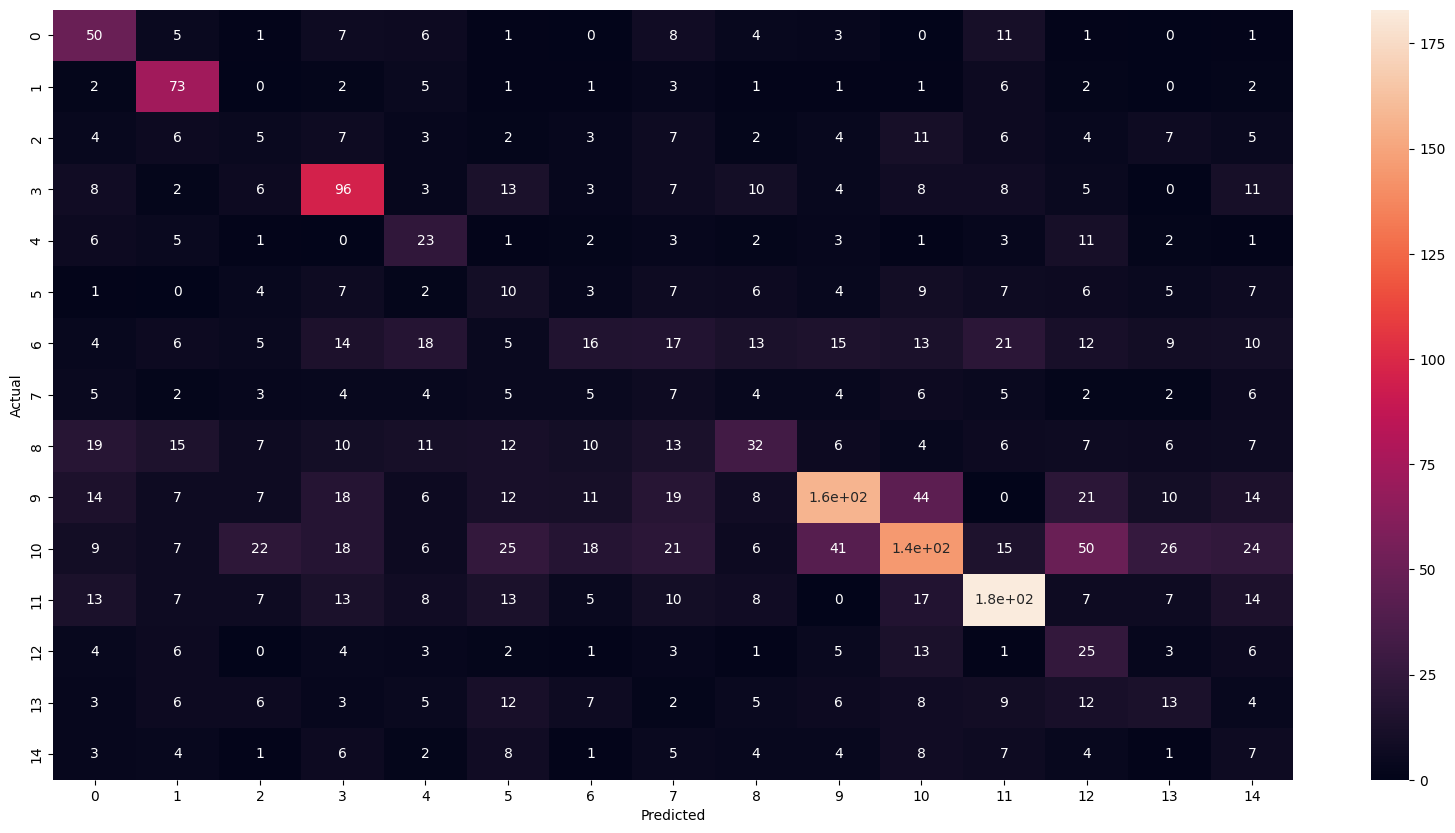

In [33]:
plt.figure(figsize=(20, 10))


# матрица ошибок confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True);
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# наблюдаем низкое качество модели: часто неверно моделью предсказываются вместо других диагнозов диазнозы
# более-менее хорошо рпредсказываются диагнозы 9, 10, 11
# сильный разброс неверных предсказаний

In [36]:
coeffecients = pd.DataFrame(lg.coef_[0], X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients.sort_values(by='Coeffecient', ascending=False)

,Coeffecient
aVL_skewness,0.262958
aVR_skewness,0.261756
age,0.221176
one_skewness,0.218816
aVF_kurtosis,0.213249
...,...
two_spectral_entropy,-0.163964
V5_skewness,-0.173173
three_skewness,-0.222382
aVF_skewness,-0.304354


<div class="alert alert-block alert-success">
    
- Положительный коэффициент логистической регрессии означает, что данный фактор повышает вероятность анализируемого исхода: наибольший коэффициент наблюдаем у aVL_skewness, aVR_skewness

- Большой коэффициент логистической регрессии означает, что данный фактор существенно влияет на вероятность: для нас это aVL_skewness, aVR_skewness

- Отрицательный коэффициент означает, что этот фактор уменьшает вероятность: наименьший отрицательный коэффициент у признака two_skewness

</div>

In [ ]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(multi_class='ovr', random_state=RAND)

param_grid = {'solver': ['saga'], 'class_weight': ['balanced'], 'penalty': ['elasticnet', 'l1'], 'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

grid_l1 = GridSearchCV(model, param_grid)

%time grid_l1.fit(X_train_std, y_train)

print(grid_l1.best_params_)

CPU times: user 1h 59min 33s, sys: 16.6 s, total: 1h 59min 50s
Wall time: 2h 34s
{'class_weight': 'balanced', 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


Наилучшая логистическая регрессия содержит следующие гиперпараметры: {'class_weight': 'balanced', 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}

In [ ]:
lg_l1 = grid_l1.best_estimator_

In [40]:
import pickle

best_model_logreg =  grid_l1.best_estimator_

filename = "best_model_logreg.pkl"

with open(filename, "wb") as file:
    pickle.dump(best_model_logreg, file)

In [37]:
from google.colab import files

files.download("best_model_logreg.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
with open("/content/gdrive/My Drive/Colab Notebooks/ecg_project/best_model_logreg.pkl", "rb") as file:
    lg_l1 = pickle.load(file)

print(lg_l1)

LogisticRegression(class_weight='balanced', l1_ratio=0.5, multi_class='ovr',
                   penalty='elasticnet', random_state=42, solver='saga')


In [42]:
y_pred_l1 = lg_l1.predict(X_test_std)
y_score_l1 = lg_l1.predict_proba(X_test_std)

metrics_l1 = get_metrics(y_train,
                lg_l1.predict(X_train_std),
                lg_l1.predict_proba(X_train_std),
                name='LogisticRegression_L1_train')

metrics_l1 = pd.concat([
    metrics_l1,
    get_metrics(y_test, y_pred_l1, y_score_l1, name='LogisticRegression_L1_test')
])

metrics = pd.concat([
    metrics,
    metrics_l1
])

metrics.set_index('model')

,Accuracy,Precision,Recall,f1,Logloss
model,,,,,
LogisticRegression_train,0.420746,0.457677,0.420746,0.426536,2.053606
LogisticRegression_test,0.359368,0.399890,0.359368,0.368385,2.213359
LogisticRegression_L1_train,0.420603,0.457294,0.420603,0.426216,2.054725
LogisticRegression_L1_test,0.360222,0.401708,0.360222,0.369712,2.213272


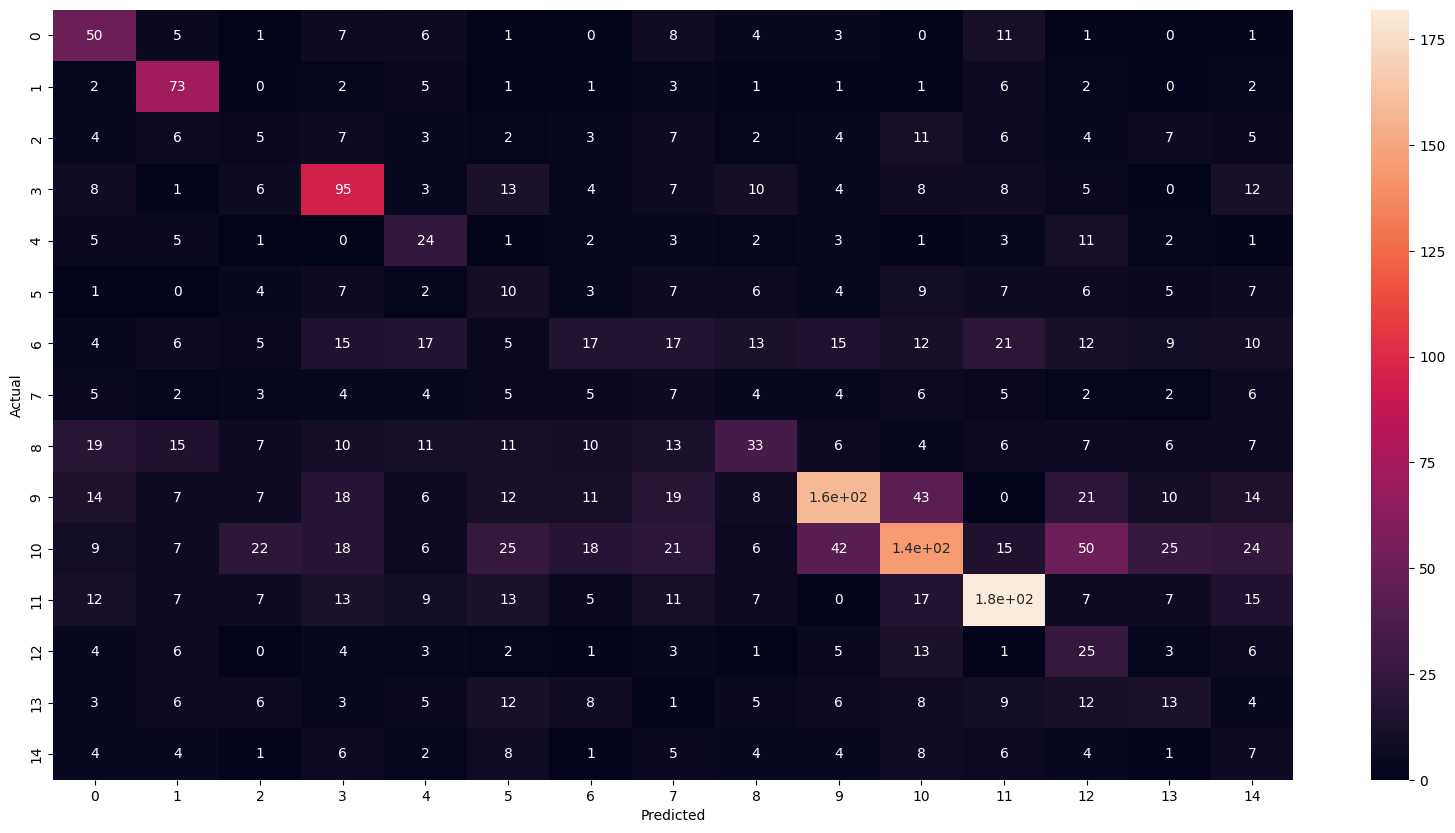

In [43]:
plt.figure(figsize=(20, 10))


# матрица ошибок confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_l1), annot=True);
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Новая модель с L1 регуляризацией справляется с предсказанием практически так же, как и логистическая регрессия без регуляризации.

In [44]:
metrics.set_index('model').style.highlight_max(color='lightgreen',
                                                            axis=0)

,Accuracy,Precision,Recall,f1,Logloss
model,,,,,
LogisticRegression_train,0.420746,0.457677,0.420746,0.426536,2.053606
LogisticRegression_test,0.359368,0.399890,0.359368,0.368385,2.213359
LogisticRegression_L1_train,0.420603,0.457294,0.420603,0.426216,2.054725
LogisticRegression_L1_test,0.360222,0.401708,0.360222,0.369712,2.213272


Кардинальных изменений в значениях метрик при добавлении регуляризации нет. Однако лучший результат показывает L2 регуляризация.

# SVM

**Гиперпараметры:**

- C - значение коэффициента регуляризации (работает обратным образом, чем меньше значение, тем больше регуляризация) {default=1.0}
- kernel - тип ядра, который будет использоваться в алгоритме {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} {default=’rbf’}
- degree - степень полиномиальной функции ядра (‘poly’). Игнорируется всеми другими ядрами {default=3}
- gamma - коэффициент ядра для ‘rbf’, ‘poly’ и ‘sigmoid’ {default=’scale’}
- probability - включить оценку вероятностей. Должно быть включено перед его вызовом, это замедлит работу этого метода, поскольку он внутренне использует 5-кратную перекрестную проверку, а predict_proba может быть несовместимым с predict.
- tol - критерий остановки (эпсилон) {default=1e-4}
- class_weight - регулировка дисбалса классов {default=None}, при дисбалансе ‘balanced’
- max_iter - max кол-во итераций в решателе {default=-1} -1 - нет ограничений
- decision_function_shape - для многоклассовой классификации {‘ovo’, ‘ovr’}

___________________________________________________________

Выбранные гиперпараметры: <br>
**decision_function_shape** - ovr (one-vs-rest) <br>
**kernel** - linear для сравнения с логрег

In [45]:
svm = SVC(probability=True, decision_function_shape='ovr', kernel='linear', random_state=RAND)
svm.fit(X_train_std, y_train)

y_pred_svm = svm.predict(X_test_std)
y_score_svm = svm.predict_proba(X_test_std)

metrics = pd.concat([
    metrics,
    get_metrics(y_train,
                svm.predict(X_train_std),
                svm.predict_proba(X_train_std),
                name='SVM_train')
])

metrics = pd.concat(
    [metrics, get_metrics(y_test, y_pred_svm, y_score_svm, name='SVM_test')])

metrics.set_index('model')

,Accuracy,Precision,Recall,f1,Logloss
model,,,,,
LogisticRegression_train,0.420746,0.457677,0.420746,0.426536,2.053606
LogisticRegression_test,0.359368,0.399890,0.359368,0.368385,2.213359
LogisticRegression_L1_train,0.420603,0.457294,0.420603,0.426216,2.054725
LogisticRegression_L1_test,0.360222,0.401708,0.360222,0.369712,2.213272
SVM_train,0.720831,0.720668,0.720831,0.710104,1.672277
SVM_test,0.395647,0.372630,0.395647,0.379695,1.949848


In [46]:
metrics = metrics.reset_index(drop=True)

In [47]:
metrics.style.highlight_max(color='lightgreen', axis=0)

,model,Accuracy,Precision,Recall,f1,Logloss
0,LogisticRegression_train,0.420746,0.457677,0.420746,0.426536,2.053606
1,LogisticRegression_test,0.359368,0.399890,0.359368,0.368385,2.213359
2,LogisticRegression_L1_train,0.420603,0.457294,0.420603,0.426216,2.054725
3,LogisticRegression_L1_test,0.360222,0.401708,0.360222,0.369712,2.213272
4,SVM_train,0.720831,0.720668,0.720831,0.710104,1.672277
5,SVM_test,0.395647,0.372630,0.395647,0.379695,1.949848


In [ ]:
import pickle

best_model_svm =  svm

filename = "best_model_svm.pkl"

with open(filename, "wb") as file:
    pickle.dump(best_model_svm, file)

In [48]:
from google.colab import files

files.download("/content/gdrive/My Drive/Colab Notebooks/ecg_project/best_model_svm.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_svc = SVC(probability=True, decision_function_shape='ovr', random_state=RAND)

param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

grid_svc = GridSearchCV(model_svc, param_grid)

%time grid_svc.fit(X_train_std, y_train)

print(grid_svc.best_params_)

CPU times: user 3h 22min 44s, sys: 13.1 s, total: 3h 22min 57s
Wall time: 3h 24min 42s
{'C': 1, 'kernel': 'rbf'}


Наилучший результат у SVM с гиперпараметрами {'C': 1, 'kernel': 'rbf'}

In [ ]:
import pickle

best_model_svc =  grid_svc.best_estimator_

filename = "best_model_svc.pkl"

with open(filename, "wb") as file:
    pickle.dump(best_model_svc, file)

In [ ]:
from google.colab import files

files.download("best_model_svc.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
with open("/content/gdrive/My Drive/Colab Notebooks/ecg_project/best_model_svc.pkl", "rb") as file:
    best_model_svc = pickle.load(file)

print(best_model_svc)

SVC(C=1, probability=True, random_state=42)


In [50]:
y_pred_svc = best_model_svc.predict(X_test_std)
y_score_svc = best_model_svc.predict_proba(X_test_std)

metrics_svc = get_metrics(y_train,
                best_model_svc.predict(X_train_std),
                best_model_svc.predict_proba(X_train_std),
                name='SVM_best_train')

metrics_svc = pd.concat([
    metrics_svc,
    get_metrics(y_test, y_pred_svc, y_score_svc, name='SVM_best_test')
])

metrics = pd.concat([
    metrics,
    metrics_svc
])

metrics.set_index('model')

,Accuracy,Precision,Recall,f1,Logloss
model,,,,,
LogisticRegression_train,0.420746,0.457677,0.420746,0.426536,2.053606
LogisticRegression_test,0.359368,0.399890,0.359368,0.368385,2.213359
LogisticRegression_L1_train,0.420603,0.457294,0.420603,0.426216,2.054725
LogisticRegression_L1_test,0.360222,0.401708,0.360222,0.369712,2.213272
SVM_train,0.720831,0.720668,0.720831,0.710104,1.672277
SVM_test,0.395647,0.372630,0.395647,0.379695,1.949848
SVM_best_train,0.666477,0.741507,0.666477,0.611807,1.059538
SVM_best_test,0.435766,0.337341,0.435766,0.367242,1.796744


In [51]:
metrics = metrics.reset_index(drop=True)

In [53]:
metrics.style.highlight_max(color='lightgreen', axis=0)

,model,Accuracy,Precision,Recall,f1,Logloss
0,LogisticRegression_train,0.420746,0.457677,0.420746,0.426536,2.053606
1,LogisticRegression_test,0.359368,0.399890,0.359368,0.368385,2.213359
2,LogisticRegression_L1_train,0.420603,0.457294,0.420603,0.426216,2.054725
3,LogisticRegression_L1_test,0.360222,0.401708,0.360222,0.369712,2.213272
4,SVM_train,0.720831,0.720668,0.720831,0.710104,1.672277
5,SVM_test,0.395647,0.372630,0.395647,0.379695,1.949848
6,SVM_best_train,0.666477,0.741507,0.666477,0.611807,1.059538
7,SVM_best_test,0.435766,0.337341,0.435766,0.367242,1.796744


Наилучшей модель выбрана SVM с типом ядра rbf. Её метрики близки по качеству к SVM с ядром linear, но для выбранной наилучшей модели наблюдаем снижение logloss, увеличение точности и не такое сильное изменение F1.